# Convolutional MNIST

In this notebook, we use convolutions to train a model on the famous MNIST dataset.

Learn more about the dataset here: [MNIST](https://en.wikipedia.org/wiki/MNIST_database)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib import layers
from show_graph import show_graph
%matplotlib inline

ImportError: No module named 'show_graph'

## Import and visualise the data

In [2]:
# Load train and test data
def load_mnist(csv_file):
    
    mnist_height, mnist_width = 28, 28
    loaded = pd.read_csv(csv_file, header=None)
    array_version = loaded.values
    labels = array_version[:, 0]
    
    # Reshape 1D images back into 2D
    images = array_version[:, 1:].reshape(-1, mnist_height, mnist_width).astype('uint8')
    
    return labels, images

train_y, train_x = load_mnist('mnist_train.csv')
test_y, test_x = load_mnist('mnist_test.csv')

In [3]:
# What's the data format?
print('Train')
print('Features: {}, labels: {}'.format(train_x.shape, train_y.shape))
print('Test')
print('Features: {}, labels: {}'.format(test_x.shape, test_y.shape))
print('Feature type: {}, label type: {}'.format(train_x.dtype, train_y.dtype))
print('Min and max pixel values: {}, {}'.format(train_x.min(), train_x.max()))

Train
Features: (60000, 28, 28), labels: (60000,)
Test
Features: (10000, 28, 28), labels: (10000,)
Feature type: uint8, label type: int64
Min and max pixel values: 0, 255


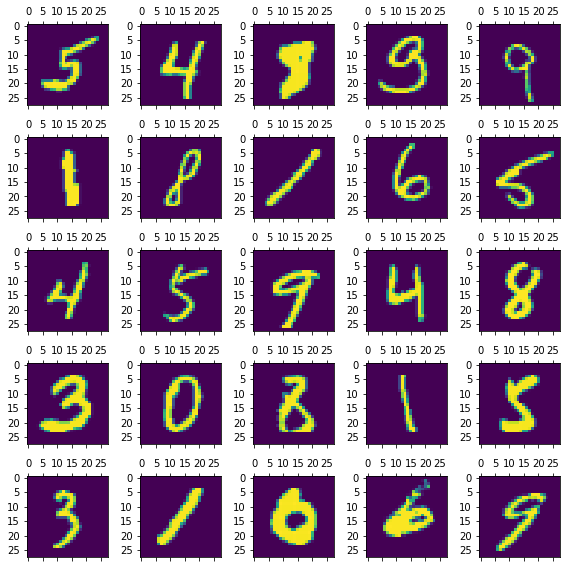

In [4]:
# Look at some sample images
chosen = np.random.choice(train_x.shape[0], size=25)
chosen_x, chosen_y = train_x[chosen], train_y[chosen]

f, ax = plt.subplots(5, 5)

for i in range(5):
    for j in range(5):
        ax[i, j].matshow(chosen_x[i * 5 + j])
        
f.set_size_inches(8, 8)
f.tight_layout()

## Model & Loss

As our basic model idea, we will be composing several convolutions. A standard "recipe" for a computer vision network is the following structure:

`[Convolution] -> [ReLU] -> [max_pool]` (repeated)

This is what we will be using here. The initial example is as follows:

* Input: `Nx28x28x1` (where N is the batch size)
* Conv1: `Nx28x28x8` (convolution with stride 1, 8 filters, followed by ReLU)
* Max_Pool1: `Nx14x14x8` (max pooling)
* Conv2: `Nx14x14x16` (convolution with stride 1, 16 filters, followed by ReLU)
* Max_Pool2: `Nx7x7x16` (max pooling)
* FC1: `Nx10` (fully-connected layer to map from the `7*7*16` features to the 10 labels).

Then, we use a softmax + cross-entropy loss.

In [24]:
# Let's set up our model.
tf.reset_default_graph()

activation = tf.nn.relu

# Placeholders for input and labels
with tf.name_scope('input'):
    x = tf.placeholder(tf.float32, shape=(None, 28, 28, 1))
    
with tf.name_scope('labels'):
    y = tf.placeholder(tf.int64, shape=(None))

# The model:
with tf.name_scope('conv1'):
    conv1 = layers.convolution2d(x, num_outputs=50, kernel_size=5, 
                                 activation_fn=activation, scope='conv1')
    
    conv1_mp = layers.max_pool2d(conv1, 2)
    
with tf.name_scope('conv2'):
    conv2 = layers.convolution2d(conv1_mp, num_outputs=16, 
                                 kernel_size=5, activation_fn=activation,
                                 scope='conv2')
    
    conv2_mp = layers.max_pool2d(conv2, 2)
    
with tf.name_scope('fc1'):
    # Reshape for the fc layer
    # We need to know the dimension of the image to reshape. After two max pools,
    # which halve both height and with, for example, we are left with 
    # 28/4 x 28/4 = 7x7. If we have 16 output channels, that means we reshape to 7*7*16.
    conv3_mp = tf.reshape(conv2_mp, (tf.shape(conv2_mp)[0], 7 * 7 * 16))
    
    fc1 = layers.fully_connected(conv3_mp, num_outputs=10, 
                                 activation_fn=None, scope='fc1')
    
# Loss: We use a cross entropy loss here.
with tf.name_scope('loss'):
    
    # Compute the average cross entropy loss across the batch
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(fc1, y))
    
with tf.name_scope('auxiliary'):
    
    # Just for our own benefit, compute the accuracy here
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.arg_max(fc1, dimension=1), y), tf.float32))

### Visualising the model

We can use [Tensorboard](https://www.tensorflow.org/how_tos/summaries_and_tensorboard/) to visualise the model. Tensorboard is a very useful tool to graph the loss over time and show the graph. Here we use it to show the model graph inside this notebook:

In [25]:
show_graph(tf.get_default_graph().as_graph_def())

You can hover over the boxes and click the (+) to expand. Does it make sense to you?

Exercise: Expand some of the boxes to see how tensorflow computes the graph.

## Prepare data

We need to be able to sample minibatches to be able to do stochastic gradient descent.

In [26]:
def sample_batch(x_data, y_data, batch_size):
    chosen = np.random.choice(x_data.shape[0], size=batch_size)
    return x_data[chosen], y_data[chosen]

Mean-centering is not strictly necessary, but we do it here to make you aware that it is commonly done. You can read more about preprocessing here:
[Image preprocessing](http://cs231n.github.io/neural-networks-2/)

In [27]:
# Mean-centre the data
mean_image = np.mean(train_x)
centred_train = (train_x - mean_image)
centred_test = (test_x - mean_image)

MNIST provides a test set, but no validation set. We produce it here by randomly picking images from the training set:

In [28]:
# Create a validation and train set
# RandomState allows us to pick a seed so that we can compare different runs
from numpy.random import RandomState
validation_set_size = 64
state = RandomState(1)
val_choices = state.choice(centred_train.shape[0], size=validation_set_size)

# Train set is inverse of validation set -- a little bit ugly in numpy
train_choices = np.ones(len(centred_train), dtype=bool)
train_choices[val_choices] = 0

# Produce training and validation sets
# We need the expand_dims to explicitly tell Tensorflow that it's a single-channel image
val_x, val_y = np.expand_dims(centred_train[val_choices], axis=3), train_y[val_choices]
model_train_x, model_train_y = np.expand_dims(centred_train[train_choices], axis=3), train_y[train_choices]

print('Shapes:')
print('Training set: {}'.format(model_train_x.shape))
print('Validation set: {}'.format(val_x.shape))

Shapes:
Training set: (59936, 28, 28, 1)
Validation set: (64, 28, 28, 1)


## Train the model with the optimizer

In [29]:
steps = 2000
batch_size = 32
learning_rate = 1e-3

# Specify the optimizer:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
train_step = optimizer.minimize(loss)

train_results = list()
val_results = list()

# Start a tensorflow session:
sess = tf.Session()

# Initialise all variables (to random starting values)
init = tf.initialize_all_variables()
sess.run(init)

# Our training loop. Train the model for the number of steps specified.
for cur_step in range(steps):

    # We get our sample batch
    cur_x, cur_y = sample_batch(model_train_x, model_train_y, batch_size=batch_size)
    
    # Run a train step
    _, cur_loss, cur_train_acc = sess.run([train_step, loss, accuracy], feed_dict={x: cur_x, y: cur_y})

    # Save the loss
    train_results.append({'loss': cur_loss, 'accuracy': cur_train_acc, 'step': cur_step})

    # Every 100 steps, run on the validation set:
    if cur_step % 100 == 0 or cur_step == steps - 1:

        cur_val_loss, cur_val_acc = sess.run([loss, accuracy], feed_dict={x: val_x, y: val_y})
        
        val_results.append({'val_loss': cur_val_loss, 'val_acc': cur_val_acc, 'step': cur_step})
        
        print('Step: {}; Validation accuracy: {}'.format(cur_step, cur_val_acc))

# Use pandas to turn our stored losses
train_results = pd.DataFrame(train_results)
val_results = pd.DataFrame(val_results)

Step: 0; Validation accuracy: 0.078125
Step: 100; Validation accuracy: 0.71875
Step: 200; Validation accuracy: 0.875
Step: 300; Validation accuracy: 0.875
Step: 400; Validation accuracy: 0.859375
Step: 500; Validation accuracy: 0.90625
Step: 600; Validation accuracy: 0.953125
Step: 700; Validation accuracy: 0.9375
Step: 800; Validation accuracy: 0.921875
Step: 900; Validation accuracy: 0.921875
Step: 1000; Validation accuracy: 0.953125
Step: 1100; Validation accuracy: 0.9375
Step: 1200; Validation accuracy: 0.921875
Step: 1300; Validation accuracy: 0.953125
Step: 1400; Validation accuracy: 0.9375
Step: 1500; Validation accuracy: 0.953125
Step: 1600; Validation accuracy: 0.96875
Step: 1700; Validation accuracy: 0.9375
Step: 1800; Validation accuracy: 0.953125
Step: 1900; Validation accuracy: 0.9375
Step: 1999; Validation accuracy: 0.953125


## Visualizing the loss

Let's have a look at the loss over time.

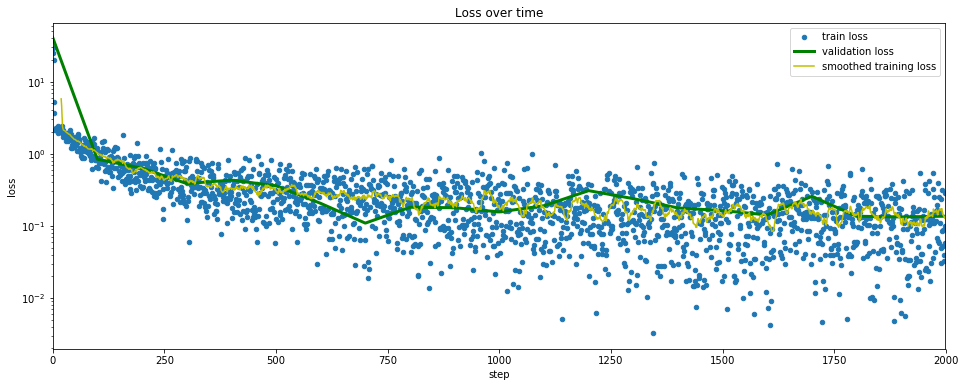

In [30]:
f, ax = plt.subplots(1, 1)

train_results.plot(x='step', y='loss', logy=True, ax=ax, kind='scatter', label='train loss')
val_results.plot(x='step', y='val_loss', logy=True, ax=ax, color='g', linewidth=3, label='validation loss')

# Plot a smoothed version of the training loss:
train_results.set_index('step').rolling(window=20).mean().plot(y='loss', logy=True, ax=ax, color='y', 
                                                               label='smoothed training loss')

f.set_size_inches(16, 6)
ax.set_title('Loss over time')

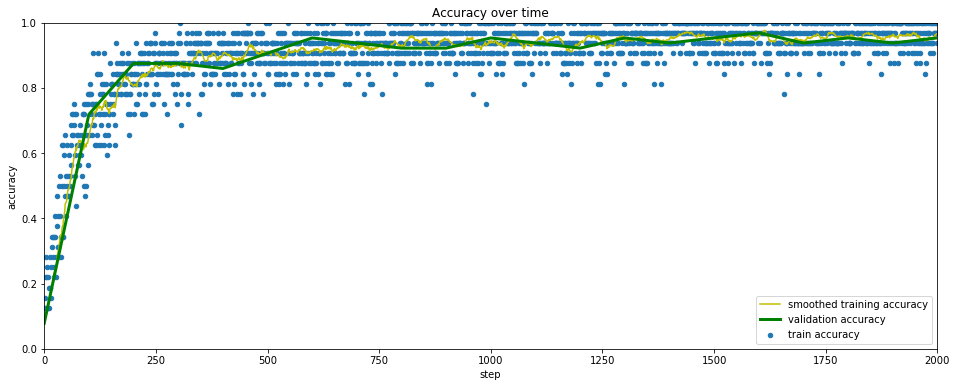

In [31]:
f, ax = plt.subplots(1, 1)

train_results.plot(x='step', y='accuracy', ax=ax, kind='scatter', label='train accuracy')
train_results.set_index('step').rolling(window=20).mean().plot(y='accuracy', ax=ax, color='y', 
                                                               label='smoothed training accuracy')
val_results.plot(x='step', y='val_acc', ax=ax, color='g', linewidth=3, label='validation accuracy')
plt.legend(loc='lower right')
ax.set_ylim([0, 1])

f.set_size_inches(16, 6)
ax.set_title('Accuracy over time')

## Run the model on the test set

With the default model, you should get something around 93-95%. Can you improve on this value?

Ideas:
* Train for more steps
* Make the model more complex (add a layer, or increase the number of convolutional filters)
    * Be careful though -- are you overfitting? If so, could regularisation help?
* Try different activation functions -- we expect ReLU to work best, is this the case?

In [32]:
test_accuracy = sess.run(accuracy, feed_dict={x: np.expand_dims(centred_test, axis=3), y: test_y})

In [33]:
print('Final accuracy: {}'.format(test_accuracy))

Final accuracy: 0.9610999822616577
